# NCAA Tournament Prediction Model
# This notebook builds a machine learning model to predict NCAA tournament game outcomes

In [104]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, confusion_matrix, classification_report
from sklearn.pipeline import Pipeline
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

In [105]:
# 1. Data Loading
print("Loading data...")

# Load tournament results
tourney_results = pd.read_csv('../raw_data/MNCAATourneyDetailedResults.csv')
print(f"Tournament results shape: {tourney_results.shape}")

# Load tournament seeds
tourney_seeds = pd.read_csv('../raw_data/MNCAATourneySeeds.csv')
print(f"Tournament seeds shape: {tourney_seeds.shape}")

# Load KenPom rankings
kenpom = pd.read_csv('../pre_tourney_data/KenPom-Rankings-Updated.csv')
print(f"KenPom rankings shape: {kenpom.shape}")

# Load enhanced stats
enhanced_stats = pd.read_csv('../pre_tourney_data/EnhancedTournamentStats.csv')
print(f"Enhanced stats shape: {enhanced_stats.shape}")

Loading data...
Tournament results shape: (1382, 34)
Tournament seeds shape: (2558, 3)
KenPom rankings shape: (7624, 5)
Enhanced stats shape: (7981, 36)


In [106]:
# 2. Data Exploration
print("\nExploring data...")

# Display sample of tournament results
print("\nSample of tournament results:")
print(tourney_results.head())

# Display sample of tournament seeds
print("\nSample of tournament seeds:")
print(tourney_seeds.head())

# Display sample of KenPom rankings
print("\nSample of KenPom rankings:")
print(kenpom.head())

# Display sample of enhanced stats
print("\nSample of enhanced stats:")
print(enhanced_stats.head())

# Check for missing values
print("\nMissing values in tournament results:")
print(tourney_results.isnull().sum())

print("\nMissing values in tournament seeds:")
print(tourney_seeds.isnull().sum())

print("\nMissing values in KenPom rankings:")
print(kenpom.isnull().sum())

print("\nMissing values in enhanced stats:")
print(enhanced_stats.isnull().sum())


Exploring data...

Sample of tournament results:
   Season  DayNum  WTeamID  WScore  LTeamID  LScore WLoc  NumOT  WFGM  WFGA  \
0    2003     134     1421      92     1411      84    N      1    32    69   
1    2003     136     1112      80     1436      51    N      0    31    66   
2    2003     136     1113      84     1272      71    N      0    31    59   
3    2003     136     1141      79     1166      73    N      0    29    53   
4    2003     136     1143      76     1301      74    N      1    27    64   

   WFGM3  WFGA3  WFTM  WFTA  WOR  WDR  WAst  WTO  WStl  WBlk  WPF  LFGM  LFGA  \
0     11     29    17    26   14   30    17   12     5     3   22    29    67   
1      7     23    11    14   11   36    22   16    10     7    8    20    64   
2      6     14    16    22   10   27    18    9     7     4   19    25    69   
3      3      7    18    25   11   20    15   18    13     1   19    27    60   
4      7     20    15    23   18   20    17   13     8     2   14    2

In [107]:
# 3. Feature Engineering
print("\nEngineering features...")

# Convert seed strings to numeric values, seeds initially look like 'W01' or 'Y16'
tourney_seeds['SeedValue'] = tourney_seeds['Seed'].str[1:3].astype(int)

def create_game_dataset(results, seeds, kenpom_data, enhanced_data):
    games = []
    
    for _, game in results.iterrows():
        season = game['Season']
        day = game['DayNum']
        
        # Get team IDs
        w_team = game['WTeamID']
        l_team = game['LTeamID']
        
        # Get seed information
        try:
            w_seed = seeds[(seeds['Season'] == season) & (seeds['TeamID'] == w_team)]['SeedValue'].values[0]
            l_seed = seeds[(seeds['Season'] == season) & (seeds['TeamID'] == l_team)]['SeedValue'].values[0]
        except:
            # Skip if seed info is missing
            continue
        
        # Get KenPom rankings (use the most recent ranking before the tournament)
        try:
            w_kenpom = kenpom_data[(kenpom_data['Season'] == season) & 
                                  (kenpom_data['TeamID'] == w_team)]['OrdinalRank'].values[0]
            l_kenpom = kenpom_data[(kenpom_data['Season'] == season) & 
                                  (kenpom_data['TeamID'] == l_team)]['OrdinalRank'].values[0]
        except:
            # Use a high default rank if KenPom data is missing
            w_kenpom = 400
            l_kenpom = 400
        
        # Get enhanced stats
        try:
            w_stats = enhanced_data[(enhanced_data['Season'] == season) & 
                                   (enhanced_data['TeamID'] == w_team)].iloc[0]
            l_stats = enhanced_data[(enhanced_data['Season'] == season) & 
                                   (enhanced_data['TeamID'] == l_team)].iloc[0]
        except:
            # Skip if enhanced stats are missing
            continue
        
        # Create feature dictionary with an upset indicator
        game_dict = {
            'Season': season,
            'DayNum': day,
            'WTeamID': w_team,
            'LTeamID': l_team,
            'WScore': game['WScore'],
            'LScore': game['LScore'],
            'ScoreDiff': game['WScore'] - game['LScore'],
            'WSeed': w_seed,
            'LSeed': l_seed,
            'SeedDiff': l_seed - w_seed,  # Higher seeds (worse teams) have higher numbers
            'WKenPom': w_kenpom,
            'LKenPom': l_kenpom,
            'KenPomDiff': l_kenpom - w_kenpom,  # Higher ranks (worse teams) have higher numbers
            'Upset': 1 if w_seed > l_seed else 0  # Upset indicator: 1 if winning team is lower seeded (higher seed value)
        }
        
        # Add enhanced stats features
        enhanced_features = [
            'AdjO', 'AdjD', 'AdjNetRtg', 'SOS_NetRtg', 'Expected Win%', 
            'ThreePtRate', 'FTRate', 'AstRate', 'TORate', 'ORRate', 'DRRate',
            'ScoreStdDev', 'MarginStdDev', 'ORtgStdDev', 'DRtgStdDev',
            'HomeWin%', 'AwayWin%', 'NeutralWin%', 'Last10Win%'
        ]
        
        for feature in enhanced_features:
            if feature in w_stats and feature in l_stats:
                game_dict[f'W_{feature}'] = w_stats[feature]
                game_dict[f'L_{feature}'] = l_stats[feature]
                game_dict[f'Diff_{feature}'] = w_stats[feature] - l_stats[feature]
        
        games.append(game_dict)
    
    return pd.DataFrame(games)


# Create game dataset
game_df = create_game_dataset(tourney_results, tourney_seeds, kenpom, enhanced_stats)
print(f"Game dataset shape: {game_df.shape}")
pd.set_option('display.max_columns', None)
game_df.tail()


Engineering features...
Game dataset shape: (1382, 71)


,Season,DayNum,WTeamID,LTeamID,WScore,LScore,ScoreDiff,WSeed,LSeed,SeedDiff,WKenPom,LKenPom,KenPomDiff,Upset,W_AdjO,L_AdjO,Diff_AdjO,W_AdjD,L_AdjD,Diff_AdjD,W_AdjNetRtg,L_AdjNetRtg,Diff_AdjNetRtg,W_SOS_NetRtg,L_SOS_NetRtg,Diff_SOS_NetRtg,W_Expected Win%,L_Expected Win%,Diff_Expected Win%,W_ThreePtRate,L_ThreePtRate,Diff_ThreePtRate,W_FTRate,L_FTRate,Diff_FTRate,W_AstRate,L_AstRate,Diff_AstRate,W_TORate,L_TORate,Diff_TORate,W_ORRate,L_ORRate,Diff_ORRate,W_DRRate,L_DRRate,Diff_DRRate,W_ScoreStdDev,L_ScoreStdDev,Diff_ScoreStdDev,W_MarginStdDev,L_MarginStdDev,Diff_MarginStdDev,W_ORtgStdDev,L_ORtgStdDev,Diff_ORtgStdDev,W_DRtgStdDev,L_DRtgStdDev,Diff_DRtgStdDev,W_HomeWin%,L_HomeWin%,Diff_HomeWin%,W_AwayWin%,L_AwayWin%,Diff_AwayWin%,W_NeutralWin%,L_NeutralWin%,Diff_NeutralWin%,W_Last10Win%,L_Last10Win%,Diff_Last10Win%
1377,2024,146,1301,1181,76,64,12,11,4,-7,58,8,-50,1,112.672630,120.558844,-7.886213,99.461093,94.760343,4.700750,13.211538,25.798501,-12.586963,7.758191,7.824644,-0.066454,0.621462,0.836715,-0.215253,0.277192,0.313503,-0.036311,0.190251,0.180822,0.009429,0.463489,0.537788,-0.074299,0.130725,0.135685,-0.004960,0.277447,0.268908,0.008539,0.722553,0.731092,-0.008539,10.999098,8.336122,2.662976,12.501428,13.468863,-0.967435,13.945035,13.092254,0.852781,12.725003,13.412058,-0.687055,0.705882,0.833333,-0.127451,0.363636,0.636364,-0.272727,0.750000,0.666667,0.083333,0.6,0.7,-0.1
1378,2024,146,1345,1397,72,66,6,1,2,1,3,7,4,0,125.647580,116.535731,9.111850,92.688300,88.378967,4.309334,32.959280,28.156764,4.802516,12.501183,11.241149,1.260034,0.865277,0.823142,0.042135,0.299782,0.329139,-0.029357,0.216206,0.199764,0.016442,0.645058,0.610478,0.034580,0.156245,0.140340,0.015905,0.292605,0.297835,-0.005231,0.707395,0.702165,0.005231,10.609369,11.207671,-0.598302,14.106803,15.028702,-0.921899,12.587798,13.575100,-0.987302,15.763971,17.253410,-1.489439,1.000000,0.875000,0.125000,0.700000,0.727273,-0.027273,0.857143,0.400000,0.457143,0.8,0.7,0.1
1379,2024,152,1163,1104,86,72,14,1,4,3,1,13,12,0,125.354291,125.465688,-0.111397,92.006455,98.190083,-6.183627,33.347836,27.275605,6.072231,6.715719,12.966760,-6.251041,0.918422,0.785970,0.132452,0.323827,0.365702,-0.041876,0.177978,0.196970,-0.018991,0.637007,0.514661,0.122346,0.136180,0.154680,-0.018500,0.286072,0.305363,-0.019292,0.713928,0.694637,0.019292,11.860899,11.755575,0.105324,15.334535,20.671685,-5.337150,13.836385,16.435703,-2.599319,15.634433,17.545395,-1.910962,1.000000,0.875000,0.125000,0.727273,0.500000,0.227273,1.000000,0.333333,0.666667,0.9,0.5,0.4
1380,2024,152,1345,1301,63,50,13,1,11,10,3,58,55,0,125.647580,112.672630,12.974950,92.688300,99.461093,-6.772792,32.959280,13.211538,19.747742,12.501183,7.758191,4.742992,0.865277,0.621462,0.243815,0.299782,0.277192,0.022590,0.216206,0.190251,0.025955,0.645058,0.463489,0.181570,0.156245,0.130725,0.025520,0.292605,0.277447,0.015158,0.707395,0.722553,-0.015158,10.609369,10.999098,-0.389729,14.106803,12.501428,1.605375,12.587798,13.945035,-1.357237,15.763971,12.725003,3.038968,1.000000,0.705882,0.294118,0.700000,0.363636,0.336364,0.857143,0.750000,0.107143,0.8,0.6,0.2
1381,2024,154,1163,1345,75,60,15,1,1,0,1,3,2,0,125.354291,125.647580,-0.293289,92.006455,92.688300,-0.681845,33.347836,32.959280,0.388556,6.715719,12.501183,-5.785464,0.918422,0.865277,0.053146,0.323827,0.299782,0.024045,0.177978,0.216206,-0.038228,0.637007,0.645058,-0.008051,0.136180,0.156245,-0.020065,0.286072,0.292605,-0.006533,0.713928,0.707395,0.006533,11.860899,10.609369,1.251530,15.334535,14.106803,1.227731,13.836385,12.587798,1.248586,15.634433,15.763971,-0.129537,1.000000,1.000000,0.000000,0.727273,0.700000,0.027273,1.000000,0.857143,0.142857,0.9,0.8,0.1


In [108]:
def create_balanced_dataset(game_df):
    # Create copies of the original dataframe
    original_df = game_df.copy()
    swapped_df = game_df.copy()
    
    # Swap key columns in swapped_df using temporary variables
    cols_to_swap = {
        'WTeamID': 'LTeamID', 'LTeamID': 'WTeamID',
        'WScore': 'LScore', 'LScore': 'WScore',
        'WSeed': 'LSeed', 'LSeed': 'WSeed',
        'WKenPom': 'LKenPom', 'LKenPom': 'WKenPom'
    }
    
    for col1, col2 in cols_to_swap.items():
        temp = swapped_df[col1].copy()
        swapped_df[col1] = swapped_df[col2]
        swapped_df[col2] = temp
    
    # Negate the derived difference columns in swapped_df
    for diff_col in ['ScoreDiff', 'SeedDiff', 'KenPomDiff']:
        if diff_col in swapped_df.columns:
            swapped_df[diff_col] = -swapped_df[diff_col]
    
    # Swap enhanced stats columns in swapped_df
    for col in game_df.columns:
        if col.startswith('W_'):
            l_col = 'L_' + col[2:]
            if l_col in game_df.columns:
                temp = swapped_df[col].copy()
                swapped_df[col] = swapped_df[l_col]
                swapped_df[l_col] = temp
        
        # For difference features, simply negate them
        if col.startswith('Diff_'):
            swapped_df[col] = -swapped_df[col]
    
    # Add target column: 1 for original (win perspective), 0 for swapped (loss perspective)
    original_df['Target'] = 1
    swapped_df['Target'] = 0
    
    # Combine the two DataFrames
    balanced_df = pd.concat([original_df, swapped_df], ignore_index=True)
    
    return balanced_df

# Create balanced dataset
balanced_df = create_balanced_dataset(game_df)
print(f"Balanced dataset shape: {balanced_df.shape}")
balanced_df.tail()


Balanced dataset shape: (2764, 72)


,Season,DayNum,WTeamID,LTeamID,WScore,LScore,ScoreDiff,WSeed,LSeed,SeedDiff,WKenPom,LKenPom,KenPomDiff,Upset,W_AdjO,L_AdjO,Diff_AdjO,W_AdjD,L_AdjD,Diff_AdjD,W_AdjNetRtg,L_AdjNetRtg,Diff_AdjNetRtg,W_SOS_NetRtg,L_SOS_NetRtg,Diff_SOS_NetRtg,W_Expected Win%,L_Expected Win%,Diff_Expected Win%,W_ThreePtRate,L_ThreePtRate,Diff_ThreePtRate,W_FTRate,L_FTRate,Diff_FTRate,W_AstRate,L_AstRate,Diff_AstRate,W_TORate,L_TORate,Diff_TORate,W_ORRate,L_ORRate,Diff_ORRate,W_DRRate,L_DRRate,Diff_DRRate,W_ScoreStdDev,L_ScoreStdDev,Diff_ScoreStdDev,W_MarginStdDev,L_MarginStdDev,Diff_MarginStdDev,W_ORtgStdDev,L_ORtgStdDev,Diff_ORtgStdDev,W_DRtgStdDev,L_DRtgStdDev,Diff_DRtgStdDev,W_HomeWin%,L_HomeWin%,Diff_HomeWin%,W_AwayWin%,L_AwayWin%,Diff_AwayWin%,W_NeutralWin%,L_NeutralWin%,Diff_NeutralWin%,W_Last10Win%,L_Last10Win%,Diff_Last10Win%,Target
2759,2024,146,1301,1181,76,64,-12,11,4,7,58,8,50,1,120.558844,112.672630,7.886213,94.760343,99.461093,-4.700750,25.798501,13.211538,12.586963,7.824644,7.758191,0.066454,0.836715,0.621462,0.215253,0.313503,0.277192,0.036311,0.180822,0.190251,-0.009429,0.537788,0.463489,0.074299,0.135685,0.130725,0.004960,0.268908,0.277447,-0.008539,0.731092,0.722553,0.008539,8.336122,10.999098,-2.662976,13.468863,12.501428,0.967435,13.092254,13.945035,-0.852781,13.412058,12.725003,0.687055,0.833333,0.705882,0.127451,0.636364,0.363636,0.272727,0.666667,0.750000,-0.083333,0.7,0.6,0.1,0
2760,2024,146,1345,1397,72,66,-6,1,2,-1,3,7,-4,0,116.535731,125.647580,-9.111850,88.378967,92.688300,-4.309334,28.156764,32.959280,-4.802516,11.241149,12.501183,-1.260034,0.823142,0.865277,-0.042135,0.329139,0.299782,0.029357,0.199764,0.216206,-0.016442,0.610478,0.645058,-0.034580,0.140340,0.156245,-0.015905,0.297835,0.292605,0.005231,0.702165,0.707395,-0.005231,11.207671,10.609369,0.598302,15.028702,14.106803,0.921899,13.575100,12.587798,0.987302,17.253410,15.763971,1.489439,0.875000,1.000000,-0.125000,0.727273,0.700000,0.027273,0.400000,0.857143,-0.457143,0.7,0.8,-0.1,0
2761,2024,152,1163,1104,86,72,-14,1,4,-3,1,13,-12,0,125.465688,125.354291,0.111397,98.190083,92.006455,6.183627,27.275605,33.347836,-6.072231,12.966760,6.715719,6.251041,0.785970,0.918422,-0.132452,0.365702,0.323827,0.041876,0.196970,0.177978,0.018991,0.514661,0.637007,-0.122346,0.154680,0.136180,0.018500,0.305363,0.286072,0.019292,0.694637,0.713928,-0.019292,11.755575,11.860899,-0.105324,20.671685,15.334535,5.337150,16.435703,13.836385,2.599319,17.545395,15.634433,1.910962,0.875000,1.000000,-0.125000,0.500000,0.727273,-0.227273,0.333333,1.000000,-0.666667,0.5,0.9,-0.4,0
2762,2024,152,1345,1301,63,50,-13,1,11,-10,3,58,-55,0,112.672630,125.647580,-12.974950,99.461093,92.688300,6.772792,13.211538,32.959280,-19.747742,7.758191,12.501183,-4.742992,0.621462,0.865277,-0.243815,0.277192,0.299782,-0.022590,0.190251,0.216206,-0.025955,0.463489,0.645058,-0.181570,0.130725,0.156245,-0.025520,0.277447,0.292605,-0.015158,0.722553,0.707395,0.015158,10.999098,10.609369,0.389729,12.501428,14.106803,-1.605375,13.945035,12.587798,1.357237,12.725003,15.763971,-3.038968,0.705882,1.000000,-0.294118,0.363636,0.700000,-0.336364,0.750000,0.857143,-0.107143,0.6,0.8,-0.2,0
2763,2024,154,1163,1345,75,60,-15,1,1,0,1,3,-2,0,125.647580,125.354291,0.293289,92.688300,92.006455,0.681845,32.959280,33.347836,-0.388556,12.501183,6.715719,5.785464,0.865277,0.918422,-0.053146,0.299782,0.323827,-0.024045,0.216206,0.177978,0.038228,0.645058,0.637007,0.008051,0.156245,0.136180,0.020065,0.292605,0.286072,0.006533,0.707395,0.713928,-0.006533,10.609369,11.860899,-1.251530,14.106803,15.334535,-1.227731,12.587798,13.836385,-1.248586,15.763971,15.634433,0.129537,1.000000,1.000000,-0.000000,0.700000,0.727273,-0.027273,0.857143,1.000000,-0.142857,0.8,0.9,-0.1,0


In [109]:
# 5. Feature Selection
print("\nSelecting features...")

# Define features to use
seed_features = ['SeedDiff']
kenpom_features = ['KenPomDiff']
enhanced_diff_features = [col for col in balanced_df.columns if col.startswith('Diff_')]

# Combine all features
features = seed_features + kenpom_features + enhanced_diff_features
print(f"Selected {len(features)} features: {features}")

# Prepare X and y
X = balanced_df[features]
y = balanced_df['Target']

# 6. Train-Test Split
print("\nSplitting data...")

# Split by season to avoid data leakage
train_seasons = balanced_df['Season'].unique()[:-3]  # Use all but the last 3 seasons for training
val_seasons = [balanced_df['Season'].unique()[-3]]   # Use third-to-last season for validation
test_seasons = balanced_df['Season'].unique()[-2:]   # Use last 2 seasons for testing

X_train = X[balanced_df['Season'].isin(train_seasons)]
y_train = y[balanced_df['Season'].isin(train_seasons)]

X_val = X[balanced_df['Season'].isin(val_seasons)]
y_val = y[balanced_df['Season'].isin(val_seasons)]

X_test = X[balanced_df['Season'].isin(test_seasons)]
y_test = y[balanced_df['Season'].isin(test_seasons)]

print(X_test)


print(f"Training set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")


Selecting features...
Selected 21 features: ['SeedDiff', 'KenPomDiff', 'Diff_AdjO', 'Diff_AdjD', 'Diff_AdjNetRtg', 'Diff_SOS_NetRtg', 'Diff_Expected Win%', 'Diff_ThreePtRate', 'Diff_FTRate', 'Diff_AstRate', 'Diff_TORate', 'Diff_ORRate', 'Diff_DRRate', 'Diff_ScoreStdDev', 'Diff_MarginStdDev', 'Diff_ORtgStdDev', 'Diff_DRtgStdDev', 'Diff_HomeWin%', 'Diff_AwayWin%', 'Diff_NeutralWin%', 'Diff_Last10Win%']

Splitting data...
      SeedDiff  KenPomDiff  Diff_AdjO  Diff_AdjD  Diff_AdjNetRtg  \
1248         0         -28   8.581414   9.695146       -1.113732   
1249         0          87   3.896983   0.112144        3.784839   
1250         0         -25  -5.884832  -2.568720       -3.316113   
1251         0         -27  11.693407  10.808369        0.885038   
1252        15         167  14.395644 -22.026006       36.421649   
...        ...         ...        ...        ...             ...   
2759         7          50   7.886213  -4.700750       12.586963   
2760        -1          -4  -9.1

In [110]:
print("\nTraining models...")

# Define models to try
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'XGBoost': xgb.XGBClassifier(random_state=42)
}

# Train and evaluate each model
results = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    
    # Create a pipeline with scaling; note that scaling is crucial for Logistic Regression
    # and not strictly needed for tree-based models, but it's okay to include for consistency.
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('model', model)
    ])
    
    # Train the model
    pipeline.fit(X_train, y_train)
    
    # Make predictions
    y_val_pred = pipeline.predict_proba(X_val)[:, 1]
    
    # Calculate metrics
    val_auc = roc_auc_score(y_val, y_val_pred)
    val_log_loss = log_loss(y_val, y_val_pred)
    
    # Store results
    results[name] = {
        'pipeline': pipeline,
        'val_auc': val_auc,
        'val_log_loss': val_log_loss
    }
    
    print(f"{name} - Validation AUC: {val_auc:.4f}, Log Loss: {val_log_loss:.4f}")

# Find the best model
best_model_name = max(results, key=lambda x: results[x]['val_auc'])
best_pipeline = results[best_model_name]['pipeline']
print(f"\nBest model: {best_model_name} with AUC: {results[best_model_name]['val_auc']:.4f}")



Training models...

Training Logistic Regression...
Logistic Regression - Validation AUC: 0.7202, Log Loss: 0.6360

Training Random Forest...
Random Forest - Validation AUC: 0.7263, Log Loss: 0.6156

Training Gradient Boosting...
Gradient Boosting - Validation AUC: 0.7180, Log Loss: 0.6348

Training XGBoost...
XGBoost - Validation AUC: 0.6908, Log Loss: 0.9056

Best model: Random Forest with AUC: 0.7263


In [111]:
print("\nTuning hyperparameters for the best model...")

if best_model_name == 'Logistic Regression':
    param_grid = {
        'model__C': [0.01, 0.1, 1, 10, 100],
        'model__penalty': ['l1', 'l2'],
        'model__solver': ['liblinear', 'saga']
    }
elif best_model_name == 'Random Forest':
    param_grid = {
        'model__n_estimators': [100, 200, 300],
        'model__max_depth': [None, 10, 20, 30],
        'model__min_samples_split': [2, 5, 10]
    }
elif best_model_name == 'Gradient Boosting':
    param_grid = {
        'model__n_estimators': [100, 200, 300],
        'model__learning_rate': [0.01, 0.1, 0.2],
        'model__max_depth': [3, 5, 7]
    }
else:  # XGBoost
    param_grid = {
        'model__n_estimators': [100, 200, 300],
        'model__learning_rate': [0.01, 0.1, 0.2],
        'model__max_depth': [3, 5, 7],
        'model__subsample': [0.8, 0.9, 1.0]
    }

# Create grid search
grid_search = GridSearchCV(
    best_pipeline,
    param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)

# Fit grid search
grid_search.fit(X_train, y_train)

# Get best parameters
best_params = grid_search.best_params_
print(f"Best parameters: {best_params}")

# Get best model
best_model = grid_search.best_estimator_

# Evaluate on validation set
y_val_pred = best_model.predict_proba(X_val)[:, 1]
val_auc = roc_auc_score(y_val, y_val_pred)
val_log_loss = log_loss(y_val, y_val_pred)
print(f"Tuned model - Validation AUC: {val_auc:.4f}, Log Loss: {val_log_loss:.4f}")

# Note: For tree-based models, the StandardScaler may not be necessary.
# You could optionally remove it for efficiency if needed.



Tuning hyperparameters for the best model...
Best parameters: {'model__max_depth': 10, 'model__min_samples_split': 2, 'model__n_estimators': 100}
Tuned model - Validation AUC: 0.7235, Log Loss: 0.6147



Evaluating on test set...
Test AUC: 0.7688
Test Log Loss: 0.5745
Test Accuracy: 0.6978

Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.69      0.70       134
           1       0.70      0.70      0.70       134

    accuracy                           0.70       268
   macro avg       0.70      0.70      0.70       268
weighted avg       0.70      0.70      0.70       268


Confusion Matrix:
[[93 41]
 [40 94]]


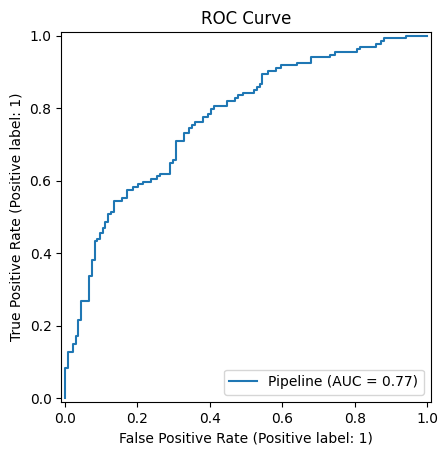

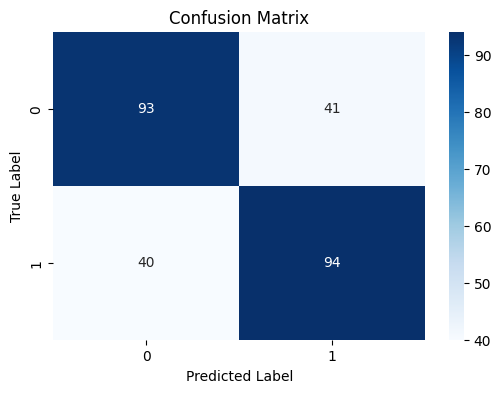

In [112]:
# 9. Final Evaluation on Test Set
print("\nEvaluating on test set...")

# Make predictions on the test set
y_test_pred_proba = best_model.predict_proba(X_test)[:, 1]
y_test_pred = best_model.predict(X_test)

# Calculate evaluation metrics
test_auc = roc_auc_score(y_test, y_test_pred_proba)
test_log_loss = log_loss(y_test, y_test_pred_proba)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"Test AUC: {test_auc:.4f}")
print(f"Test Log Loss: {test_log_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Print detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred))

# Print confusion matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_test_pred)
print(cm)

# Plot ROC curve
from sklearn.metrics import RocCurveDisplay
RocCurveDisplay.from_estimator(best_model, X_test, y_test)
plt.title("ROC Curve")
plt.show()

# Plot confusion matrix as a heatmap for better visualization
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()



Analyzing feature importance...

Top 15 most important features:
               Feature  Importance
4       Diff_AdjNetRtg    0.135505
1           KenPomDiff    0.109547
2            Diff_AdjO    0.075215
0             SeedDiff    0.071803
3            Diff_AdjD    0.070201
6   Diff_Expected Win%    0.047966
5      Diff_SOS_NetRtg    0.045987
9         Diff_AstRate    0.043808
8          Diff_FTRate    0.037466
17       Diff_HomeWin%    0.034474
10         Diff_TORate    0.033650
18       Diff_AwayWin%    0.033638
7     Diff_ThreePtRate    0.032424
12         Diff_DRRate    0.031181
11         Diff_ORRate    0.030842


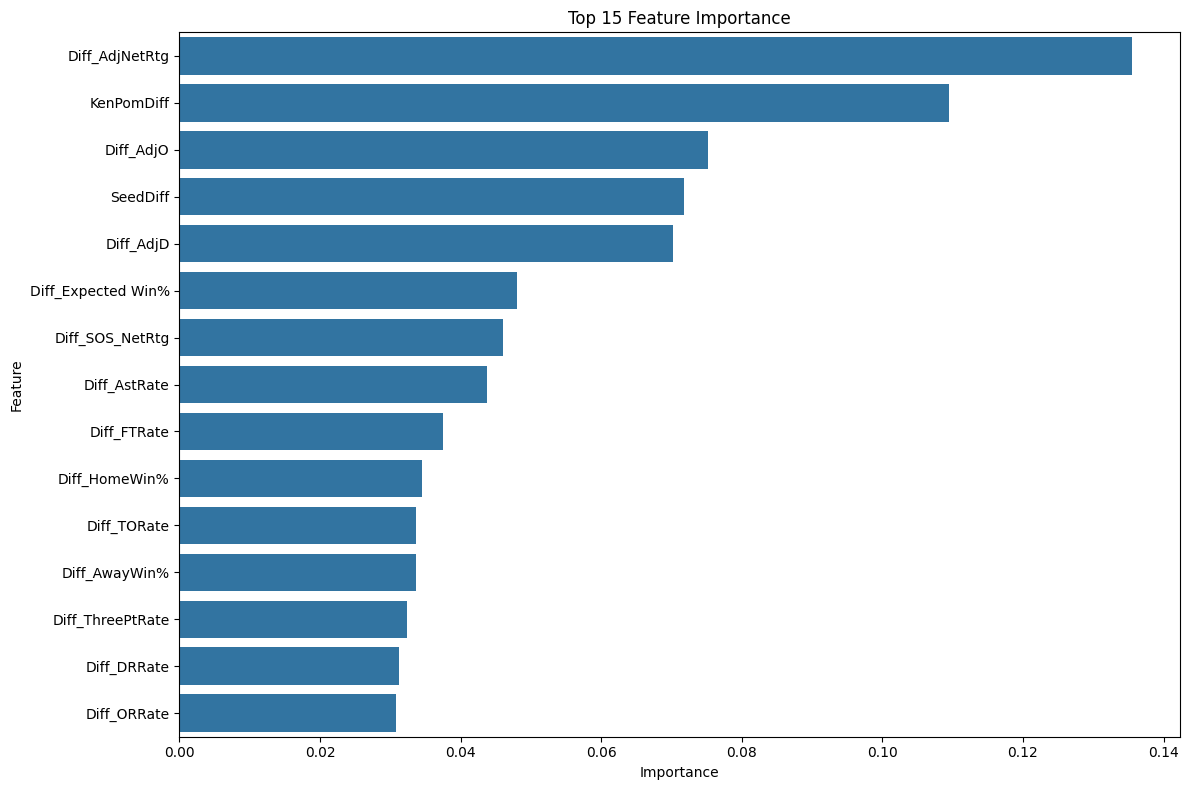

In [113]:
# 10. Feature Importance Analysis
print("\nAnalyzing feature importance...")

# Retrieve the final estimator from the pipeline using named_steps for robustness
model_estimator = best_model.named_steps['model'] if hasattr(best_model, 'named_steps') else best_model[-1]

# Get feature importance based on available attributes
if hasattr(model_estimator, 'feature_importances_'):
    importances = model_estimator.feature_importances_
elif hasattr(model_estimator, 'coef_'):
    importances = np.abs(model_estimator.coef_[0])
else:
    # As a fallback, we could compute permutation importance, or use zeros
    importances = np.zeros(len(features))
    print("Warning: Model does not provide built-in feature importance attributes.")

# Create a DataFrame for feature importance
feature_importance = pd.DataFrame({
    'Feature': features,
    'Importance': importances
})

# Sort features by importance in descending order
feature_importance = feature_importance.sort_values('Importance', ascending=False)

# Display top 15 features
print("\nTop 15 most important features:")
print(feature_importance.head(15))

# Plot the top 15 feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance.head(15))
plt.title('Top 15 Feature Importance')
plt.tight_layout()
plt.savefig('feature_importance.png')
plt.show()



Analyzing model performance by seed difference...
  SeedDiff_bin  Count  Actual_Win_Rate  Predicted_Win_Rate  Avg_Probability
0   [-20, -10]     25         0.120000            0.000000         0.114192
1    [-10, -5]     52         0.288462            0.057692         0.288152
2     [-5, -1]     48         0.416667            0.270833         0.417382
3      [-1, 1]     39         0.512821            0.641026         0.522939
4       [1, 5]     41         0.609756            0.804878         0.634163
5      [5, 10]     39         0.769231            0.948718         0.731555
6     [10, 20]     24         0.875000            1.000000         0.887638


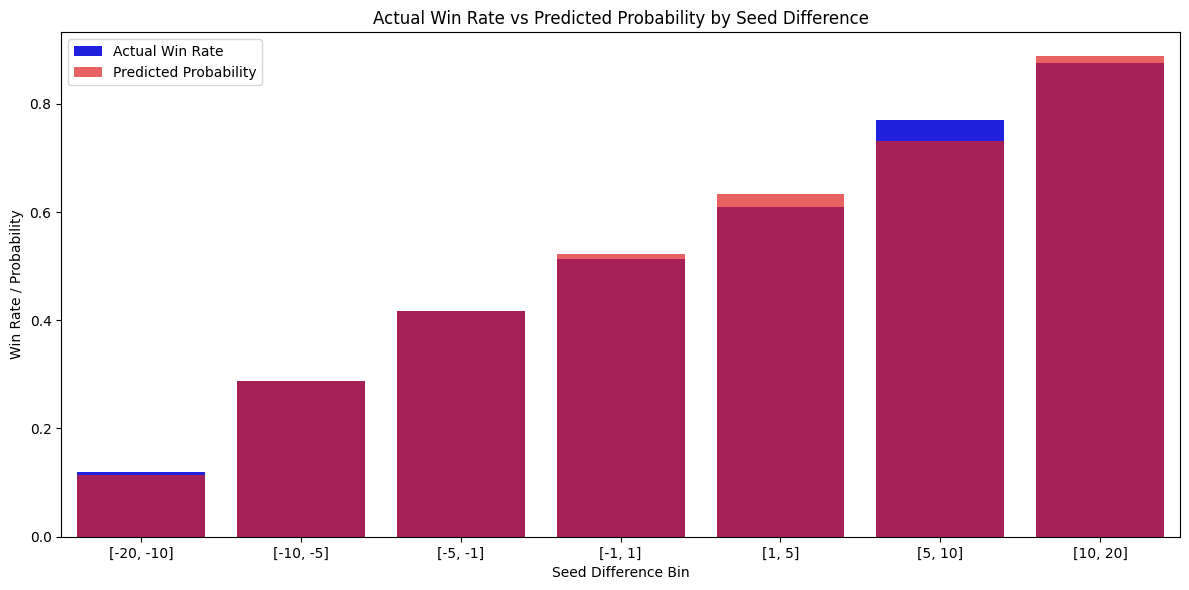

In [114]:
# 11. Analyze model performance by seed difference
print("\nAnalyzing model performance by seed difference...")

# Create a dataframe with predictions and actual values
test_results = pd.DataFrame({
    'SeedDiff': X_test['SeedDiff'],
    'Actual': y_test,
    'Predicted': y_test_pred,
    'Probability': y_test_pred_proba
})

# Define bins and corresponding labels for seed differences
bins = [-20, -10, -5, -1, 1, 5, 10, 20]
labels = ["[-20, -10]", "[-10, -5]", "[-5, -1]", "[-1, 1]", "[1, 5]", "[5, 10]", "[10, 20]"]

# Create a new column for binned seed differences
test_results['SeedDiff_bin'] = pd.cut(test_results['SeedDiff'], bins=bins, labels=labels)

# Group by the binned seed difference and calculate metrics
seed_diff_performance = test_results.groupby('SeedDiff_bin').agg(
    Count=('SeedDiff', 'count'),
    Actual_Win_Rate=('Actual', 'mean'),
    Predicted_Win_Rate=('Predicted', 'mean'),
    Avg_Probability=('Probability', 'mean')
).reset_index()

print(seed_diff_performance)

# Plot actual win rate vs predicted probability by seed difference
plt.figure(figsize=(12, 6))
# Plot Actual Win Rate
sns.barplot(x='SeedDiff_bin', y='Actual_Win_Rate', data=seed_diff_performance, color='blue', label='Actual Win Rate')
# Plot Predicted Probability
sns.barplot(x='SeedDiff_bin', y='Avg_Probability', data=seed_diff_performance, color='red', label='Predicted Probability', alpha=0.7)

plt.title('Actual Win Rate vs Predicted Probability by Seed Difference')
plt.xlabel('Seed Difference Bin')
plt.ylabel('Win Rate / Probability')
plt.legend()
plt.tight_layout()
plt.savefig('seed_diff_performance.png')
plt.show()


In [115]:
print("\nSample matchup predictions:")

# Filter the balanced test set for original perspective rows (Target == 1)
test_df = balanced_df[balanced_df['Season'].isin(test_seasons)]
test_original = test_df[test_df['Target'] == 1].copy()

# Compute predictions on these rows
X_test_original = test_original[features]
test_original['Predicted_Prob'] = best_model.predict_proba(X_test_original)[:, 1]
test_original['Predicted_Class'] = best_model.predict(X_test_original)

# For these rows, the actual winner is Team1 (WTeamID)
# We'll mark the prediction as correct if the predicted probability is >= 0.5
test_original['Prediction_Correct'] = test_original['Predicted_Prob'].apply(lambda x: "Yes" if x >= 0.5 else "No")

# Load team names from CSV (if available)
try:
    teams_df = pd.read_csv("../raw_data/MTeams.csv")
    teams_dict = dict(zip(teams_df['TeamID'], teams_df['TeamName']))
    print(f"Loaded {len(teams_dict)} team names")
except FileNotFoundError:
    print("MTeams.csv not found. Using TeamIDs instead.")
    teams_dict = {}

# Map team IDs to team names for display
test_original['Team1'] = test_original['WTeamID'].map(teams_dict)
test_original['Team2'] = test_original['LTeamID'].map(teams_dict)

# Since these rows represent the original perspective, the actual winner is Team1
test_original['Actual_Winner'] = test_original['Team1']

# Select and rename columns for clarity, including seeds for each team
sample_predictions = test_original[['Season', 'Team1', 'Team2', 'WSeed', 'LSeed', 
                                      'Predicted_Prob', 'Actual_Winner', 'Prediction_Correct']].copy()

# Rename seed columns for clarity
sample_predictions = sample_predictions.rename(columns={'WSeed': 'Team1_Seed', 'LSeed': 'Team2_Seed'})

# Format the predicted probability as a percentage for readability
sample_predictions['Predicted_Prob'] = sample_predictions['Predicted_Prob'].apply(lambda x: f"{x:.1%}")

# Take a random sample of 10 matchups for display
sample_predictions = sample_predictions.sample(20)

print("\nSample matchup predictions (each row shows the season, team names, seeds, the model's predicted win probability for Team1, the actual winner, and whether the prediction was correct):")
sample_predictions


Sample matchup predictions:
Loaded 380 team names

Sample matchup predictions (each row shows the season, team names, seeds, the model's predicted win probability for Team1, the actual winner, and whether the prediction was correct):


,Season,Team1,Team2,Team1_Seed,Team2_Seed,Predicted_Prob,Actual_Winner,Prediction_Correct
1349,2024,Utah St,TCU,8,9,50.0%,Utah St,No
1272,2023,FL Atlantic,Memphis,9,8,55.4%,FL Atlantic,Yes
1301,2023,FL Atlantic,Tennessee,9,4,34.6%,FL Atlantic,No
1289,2023,Tennessee,Duke,4,5,65.9%,Tennessee,Yes
1354,2024,Illinois,Duquesne,3,11,78.9%,Illinois,Yes
1303,2023,Kansas St,Michigan St,3,7,57.6%,Kansas St,Yes
1257,2023,Houston,N Kentucky,1,16,96.0%,Houston,Yes
1334,2024,Washington St,Drake,7,10,61.5%,Washington St,Yes
1296,2023,Kansas St,Kentucky,3,6,45.2%,Kansas St,No
1351,2024,Arizona,Dayton,2,7,75.0%,Arizona,Yes


In [116]:
# upset analysis
print("\nFiltering to only show games where the lower seed wins (upsets)...")

# Using the 'test_original' DataFrame from earlier (original perspective where Target==1)
# Filter for upset games: winning team's seed (WSeed) is greater than the losing team's seed (LSeed)
upset_games = test_original[test_original['WSeed'] > test_original['LSeed']].copy()

# Map team names if not already mapped
try:
    teams_df = pd.read_csv("../raw_data/MTeams.csv")
    teams_dict = dict(zip(teams_df['TeamID'], teams_df['TeamName']))
except FileNotFoundError:
    teams_dict = {}

upset_games['Team1'] = upset_games['WTeamID'].map(teams_dict)
upset_games['Team2'] = upset_games['LTeamID'].map(teams_dict)
# In these rows, Team1 is the actual winner (by original perspective)
upset_games['Actual_Winner'] = upset_games['Team1']

# Rename seed columns for clarity
upset_games = upset_games.rename(columns={'WSeed': 'Team1_Seed', 'LSeed': 'Team2_Seed'})

# Select and format the desired columns:
upset_display = upset_games[['Season', 'Team1', 'Team2', 'Team1_Seed', 'Team2_Seed', 
                             'Predicted_Prob', 'Actual_Winner', 'Prediction_Correct']].copy()
upset_display['Predicted_Prob'] = upset_display['Predicted_Prob'].apply(lambda x: f"{x:.1%}")

# Sample 10 upset games to display (or show all if preferred)
sample_upsets = upset_display.sample(15)

print("\nSample upset game predictions:")
sample_upsets


Filtering to only show games where the lower seed wins (upsets)...

Sample upset game predictions:


,Season,Team1,Team2,Team1_Seed,Team2_Seed,Predicted_Prob,Actual_Winner,Prediction_Correct
1367,2024,Alabama,North Carolina,4,1,50.5%,Alabama,Yes
1350,2024,Yale,Auburn,13,4,14.1%,Yale,No
1370,2024,Illinois,Iowa St,3,2,52.3%,Illinois,Yes
1360,2024,Clemson,Baylor,6,3,38.6%,Clemson,No
1254,2023,Auburn,Iowa,9,8,52.7%,Auburn,Yes
1330,2024,Oakland,Kentucky,14,3,11.8%,Oakland,No
1371,2024,Duke,Houston,4,1,33.2%,Duke,No
1328,2024,NC State,Texas Tech,11,6,37.3%,NC State,No
1309,2023,FL Atlantic,Kansas St,9,3,63.5%,FL Atlantic,Yes
1305,2023,Miami FL,Houston,5,1,25.2%,Miami FL,No



Analyzing feature importance...
Best Model Pipeline:
Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 RandomForestClassifier(max_depth=10, random_state=42))])

Type of final_model: <class 'sklearn.ensemble._forest.RandomForestClassifier'>
Attributes of final_model (sample):
['_abc_impl', '_build_request_for_signature', '_check_feature_names', '_check_n_features', '_compute_oob_predictions', '_doc_link_module', '_doc_link_template', '_doc_link_url_param_generator', '_estimator_type', '_get_default_requests']


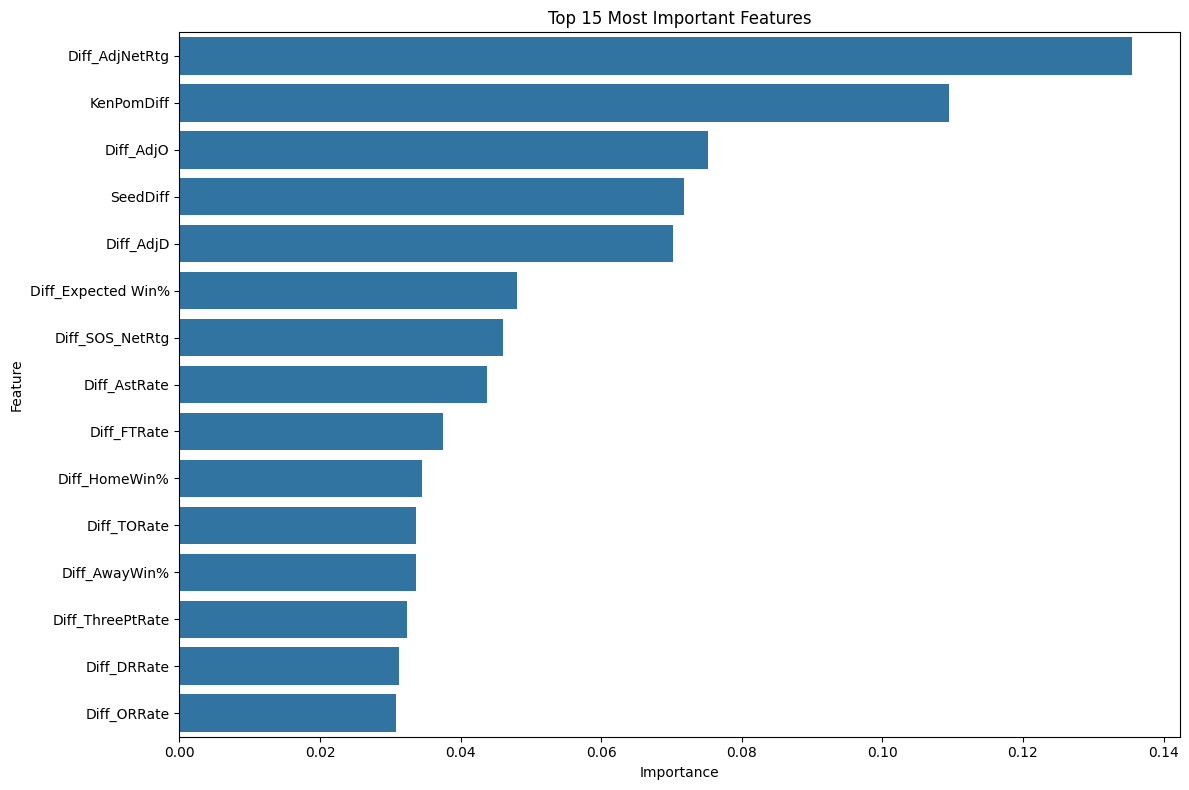


Top 10 most important features:
               Feature  Importance
4       Diff_AdjNetRtg    0.135505
1           KenPomDiff    0.109547
2            Diff_AdjO    0.075215
0             SeedDiff    0.071803
3            Diff_AdjD    0.070201
6   Diff_Expected Win%    0.047966
5      Diff_SOS_NetRtg    0.045987
9         Diff_AstRate    0.043808
8          Diff_FTRate    0.037466
17       Diff_HomeWin%    0.034474


In [117]:
# 13. Feature Importance Analysis
print("\nAnalyzing feature importance...")
print("Best Model Pipeline:")
print(best_model)

# Access the final estimator from the pipeline using the 'named_steps' attribute
final_model = best_model.named_steps['model']

# Debug: Print the type and attributes of final_model
print(f"\nType of final_model: {type(final_model)}")
print("Attributes of final_model (sample):")
print([attr for attr in dir(final_model) if not attr.startswith('__')][:10])  # Show a sample of attributes

# Try to get feature importance
if hasattr(final_model, 'feature_importances_'):
    # For tree-based models
    importances = final_model.feature_importances_
    feature_importance = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': importances
    }).sort_values('Importance', ascending=False)
    
    # Plot feature importance
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=feature_importance.head(15))
    plt.title('Top 15 Most Important Features')
    plt.tight_layout()
    plt.show()
    
    print("\nTop 10 most important features:")
    print(feature_importance.head(10))
    
elif hasattr(final_model, 'coef_'):
    # For linear models, sort by absolute coefficient values for better interpretability
    coefficients = final_model.coef_[0]
    feature_importance = pd.DataFrame({
        'Feature': X_train.columns,
        'Coefficient': coefficients,
        'AbsCoefficient': np.abs(coefficients)
    }).sort_values('AbsCoefficient', ascending=False)
    
    # Plot the top 15 features based on absolute coefficient values
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Coefficient', y='Feature', data=feature_importance.head(15))
    plt.title('Top 15 Features (Sorted by Absolute Coefficient)')
    plt.tight_layout()
    plt.show()
    
    print("\nTop 10 features with highest absolute coefficients:")
    print(feature_importance[['Feature', 'Coefficient', 'AbsCoefficient']].head(10))
else:
    # Fallback: Model doesn't provide built-in importance attributes
    print("Model does not provide feature importance or coefficient attributes.")
    # Optionally, you can compute permutation importance here


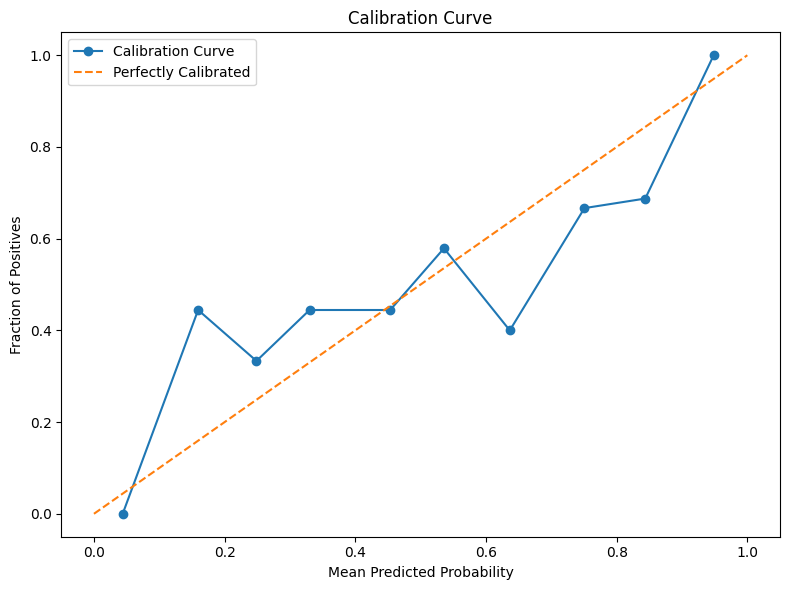

In [118]:
from sklearn.calibration import calibration_curve

# Get predicted probabilities for the validation set
prob_true, prob_pred = calibration_curve(y_val, best_model.predict_proba(X_val)[:, 1], n_bins=10)

plt.figure(figsize=(8, 6))
plt.plot(prob_pred, prob_true, marker='o', label='Calibration Curve')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly Calibrated')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Curve')
plt.legend()
plt.tight_layout()
plt.show()


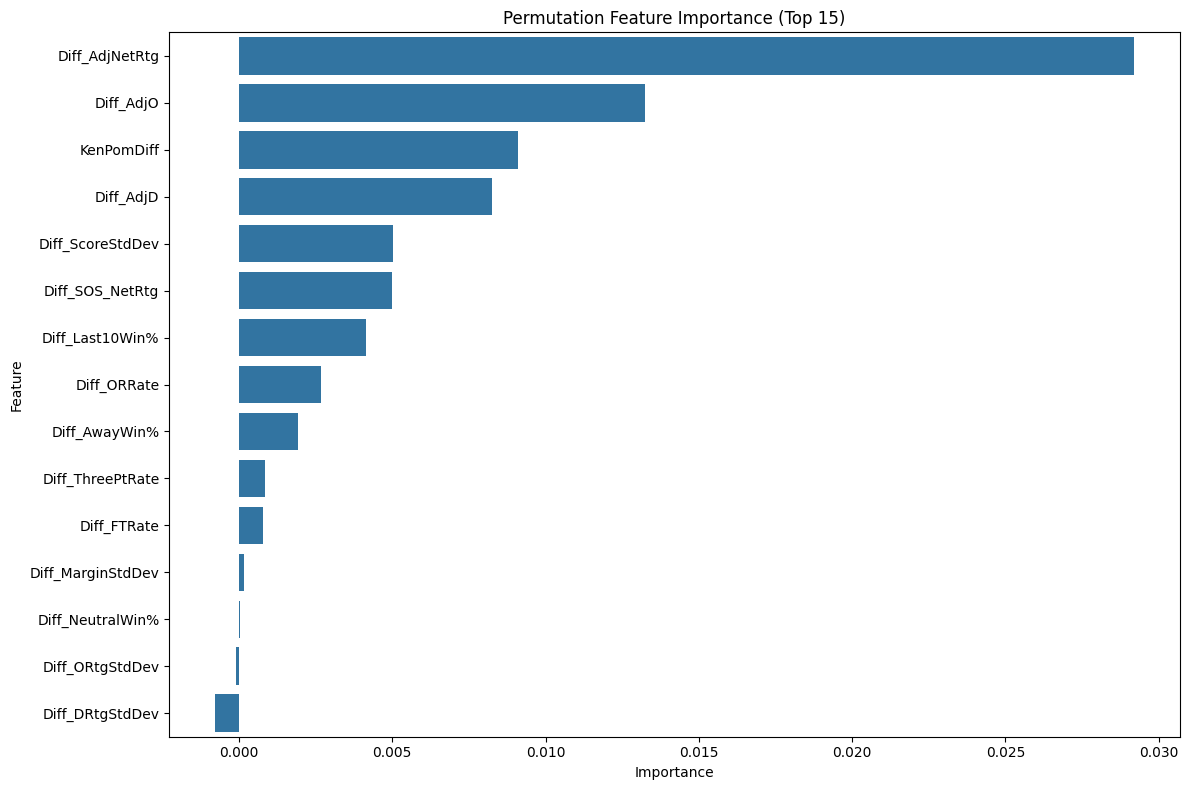

Permutation Importance (Top 10):
             Feature  Importance
4     Diff_AdjNetRtg    0.029182
2          Diff_AdjO    0.013255
1         KenPomDiff    0.009089
3          Diff_AdjD    0.008242
13  Diff_ScoreStdDev    0.005012
5    Diff_SOS_NetRtg    0.004990
20   Diff_Last10Win%    0.004143
11       Diff_ORRate    0.002673
18     Diff_AwayWin%    0.001916
7   Diff_ThreePtRate    0.000847


In [119]:
from sklearn.inspection import permutation_importance

perm_importance = permutation_importance(best_model, X_val, y_val, scoring='roc_auc', n_repeats=10, random_state=42)
perm_importance_df = pd.DataFrame({
    'Feature': X_val.columns,
    'Importance': perm_importance.importances_mean
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=perm_importance_df.head(15))
plt.title('Permutation Feature Importance (Top 15)')
plt.tight_layout()
plt.show()

print("Permutation Importance (Top 10):")
print(perm_importance_df.head(10))


In [121]:
# save the preliminary model
import joblib

# Save the model to a file
joblib.dump(best_model, 'final_model.pkl')

['final_model.pkl']